# Due popolazioni

In [1]:
# plots will be shown inline 
%matplotlib inline 
import matplotlib.pyplot as plt

import numpy
from numpy import sqrt,floor
import numpy.random as rnd

import numpy as np
import scipy as sp
from scipy import stats

from scipy.optimize import curve_fit

import pandas as pd
import random

import math

### Costanti

In [2]:
mu=0.5 #prob di scegliere 2 individui

#rate competizioni
c11=0.5
c12=0
c21=0
c22=0.5

#rate nascite
b1=0.5
b2=0.5

#rate morti
d1=0.5
d2=0.5


N=400 #numero totale posti 
n_0A=N/4 #numero iniziale pop A
n_0B=N/4 #numero iniziale pop B

fi0A=n_0A/N #densità iniziale
fi0B=n_0B/N #densità iniziale


### Probabilità di transire

In [3]:
def TAm(n,m): #n-> n-1
    
    if(n<=0 or n>=N+1 ):
        return (0)
    else:
        return (mu*c11*n*(n-1)/(N*(N-1))+(1-mu)*d1*n/N+2*mu*c12*m*n/(N*(N-1)))


     
def TBm(n,m): #m-> m-1
    
    if(m<=0 or m>=N+1 ):
        return (0)
    else:
        return (mu*c22*m*(m-1)/(N*(N-1))+(1-mu)*d2*m/N+2*mu*c21*m*n/(N*(N-1)))
    
def TAp(n,m): #n-> n+1
    if(n<=-1 or n>=N ):
        return (0)
    else:
        return (2*b1*mu*n*(N-n-m)/(N*(N-1)))
    
def TBp(n,m): #n-> n+1
    if(n<=-1 or n>=N ):
        return (0)
    else:
        return (2*b2*mu*m*(N-n-m)/(N*(N-1)))

## Mappe logistiche

In [4]:
#funzione
def logistica(NA,NB,r_a,a_aa,a_ab): 
    
    return(NA*(r_a-a_aa*NA-a_ab*NB))


### Runge-Kutta 4 per integrare mappa

In [5]:
def rungekutta4(f, y0,x0,r_a,r_b,a_aa,a_bb,a_ab,a_ba, t):   #per integrare mappe logistiche
    n = len(t) 
    y = np.zeros(n)
    x = np.zeros(n)
    y[0]=y0      #NA
    x[0]=x0      #NB
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1A= f(y[i],x[i],r_a,a_aa,a_ab)
        k1B= f(x[i],y[i],r_b,a_bb,a_ba)
        
        k2A = f(y[i] + k1A * h / 2.,x[i] + k1B * h / 2.,r_a,a_aa,a_ab)
        k2B = f(x[i] + k1B * h / 2.,y[i] + k1A * h / 2.,r_b,a_bb,a_ba)
        
        k3A = f(y[i] + k2A * h / 2.,x[i] + k2B * h / 2.,r_a,a_aa,a_ab)
        k3B = f(x[i] + k2B * h / 2.,y[i] + k2A * h / 2.,r_b,a_bb,a_ba)
        
        k4A = f(y[i] + k3A * h,x[i] + k3B * h,r_a,a_aa,a_ab)
        k4B = f(x[i] + k3B * h,y[i] + k3A * h,r_b,a_bb,a_ba)
        
        y[i+1] = y[i] + (h / 6.) * (k1A + 2*k2A + 2*k3A + k4A)
        x[i+1]=x[i] + (h / 6.) * (k1B + 2*k2B + 2*k3B + k4B)
    return y,x  


### Funzione varianza teorica

In [6]:
def da10_dfi(fi,psi):                             
    return(2*bt1*(1-fi-psi)-2*bt1*fi-2*ct11*fi-dt1-2*ct12*psi)

def da10_dpsi(fi):                                     
    return(-2*bt1*fi-2*ct11*fi)



def db10_dpsi(fi,psi):                             
    return(2*bt2*(1-fi-psi)-2*bt2*psi-2*ct22*psi-dt2-2*ct21*fi)  

def db10_dfi(psi):                                     
    return(-2*bt2*psi-2*ct22*psi)




def a20(fi,psi):                                  
    return(2*bt1*fi*(1-fi-psi)+ct11*fi**2+dt1*fi+2*ct12*fi*psi)

def b20(fi,psi):                                  
    return(2*bt2*psi*(1-fi-psi)+ct22*psi**2+dt2*psi+2*ct21*fi*psi)



def dxi2_dt(xi2,xi_eta,fi,psi):  
    return(2*da10_dfi(fi,psi)*xi2+2*da10_dpsi(fi)*xi_eta)+a20(fi,psi)


def deta2_dt(eta2,xi_eta,fi,psi):  
    return(2*db10_dfi(psi)*eta2+2*db10_dpsi(fi,psi)*xi_eta)+b20(fi,psi)

def dxi_eta_dt(xi2,eta2,xi_eta,fi,psi):  
    return(da10_dfi(fi,psi)*(xi_eta)+db10_dfi(psi)*(xi_eta)+da10_dpsi(fi)*eta2+db10_dpsi(fi,psi)*xi2)





def rk_var(dxi2_dt,deta2_dt,dxi_eta_dt,fi,psi,t):  
    n = len(t) 
    
    
    xi2   = np.zeros(n)
    eta2  = np.zeros(n)
    xieta = np.zeros(n)

    
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k = fi[i+1]-fi[i]
        j = psi[i+1]-psi[i]
        
        
        k1A= dxi2_dt(xi2[i],xieta[i],fi[i],psi[i])
        k1B= deta2_dt(eta2[i],xieta[i],fi[i],psi[i])
        k1C= dxi_eta_dt(xi2[i],eta2[i],xieta[i],fi[i],psi[i])
        
        
        k2A= dxi2_dt(xi2[i]+ k1A * h / 2.,xieta[i]+ k1C * h / 2.,fi[i]+k/2.,psi[i]+j/2)
        k2B= deta2_dt(eta2[i]+ k1B * h / 2.,xieta[i]+ k1C * h / 2.,fi[i]+k/2.,psi[i]+j/2)
        k2C= dxi_eta_dt(xi2[i]+ k1A * h / 2.,eta2[i]+ k1B * h / 2.,xieta[i]+ k1C * h / 2.,fi[i]+k/2.,psi[i]+j/2.)
        
        k3A= dxi2_dt(xi2[i]+ k2A * h / 2.,xieta[i]+ k2C * h / 2.,fi[i]+k/2.,psi[i]+j/2)
        k3B= deta2_dt(eta2[i]+ k2B * h / 2.,xieta[i]+ k2C * h / 2.,fi[i]+k/2.,psi[i]+j/2)
        k3C= dxi_eta_dt(xi2[i]+ k2A * h / 2.,eta2[i]+ k2B * h / 2.,xieta[i]+ k2C * h / 2.,fi[i]+k/2.,psi[i]+j/2.)
        
        k4A= dxi2_dt(xi2[i]+ k3A * h ,xieta[i]+ k3C * h ,fi[i]+k,psi[i]+j)
        k4B= deta2_dt(eta2[i]+ k3B * h ,xieta[i]+ k3C * h ,fi[i]+k,psi[i]+j)
        k4C= dxi_eta_dt(xi2[i]+ k3A * h,eta2[i]+ k3B * h ,xieta[i]+ k3C ,fi[i]+k,psi[i]+j)
        
        xi2[i+1]=xi2[i]     + (h / 6.) * (k1A + 2*k2A + 2*k3A + k4A)
        eta2[i+1]=eta2[i]   + (h / 6.) * (k1B + 2*k2B + 2*k3B + k4B)
        xieta[i+1]=xieta[i] + (h / 6.) * (k1C + 2*k2C + 2*k3C + k4C)
        
    return xi2,eta2 ,xieta

### Funzione simulazione

In [7]:
def nascita_morte(n,m,t_max):
    t=0
    for t in range(0, t_max, 1):
        rand=rnd.random()
        
        if(rand<TAm(n[t],m[t])):
            n[t+1]=n[t]-1
            m[t+1]=m[t]
            
                        
        elif(rand>=TAm(n[t],m[t]) and rand<TAm(n[t],m[t])+TAp(n[t],m[t])):
            n[t+1]=n[t]+1
            m[t+1]=m[t]
            
        elif(rand>=TAm(n[t],m[t])+TAp(n[t],m[t]) and rand<TAm(n[t],m[t])+TAp(n[t],m[t])+TBm(n[t],m[t])):
            n[t+1]=n[t]
            m[t+1]=m[t]-1
            
        elif(rand>=TAm(n[t],m[t])+TAp(n[t],m[t])+TBm(n[t],m[t]) and rand<TAm(n[t],m[t])+TAp(n[t],m[t])+TBm(n[t],m[t])+TBp(n[t],m[t])):
            n[t+1]=n[t]
            m[t+1]=m[t]+1
            
            
        else:
            n[t+1]=n[t]
            m[t+1]=m[t]
            
            
            
            
                
           

### Definizione matrici

In [8]:
def matrix(x,y):
    matrix = []
    
    for i in range(x):
        n = []

        for j in range(y):
            number = 0  
            n.insert(i,number)

        matrix.append(n)

    return matrix

# Confronto MF-simulazione

## N=400 non interagenti

In [ ]:
t_max=10000

n=np.zeros(t_max)
m=np.zeros(t_max)

n[0]=n_0A
m[0]=n_0B

ntot=np.zeros(t_max)
mtot=np.zeros(t_max)

ntot2=np.zeros(t_max)
mtot2=np.zeros(t_max)
nmtot=np.zeros(t_max)

samples=1000

for i in range (0,samples):
    
    nascita_morte(n,m,t_max-1)
    ntot=ntot+n
    mtot=mtot+m
    
    ntot2=ntot2+n**2
    mtot2=mtot2+m**2
    nmtot=nmtot+n*m
    
    
    
nMedio=ntot/samples
mMedio=mtot/samples

fi_medioA=nMedio/N
fi_medioB=mMedio/N

n2Medio=ntot2/samples
m2Medio=mtot2/samples
nmMedio=nmtot/samples


var_n=n2Medio-nMedio**2
var_m=m2Medio-mMedio**2
cov_nm=nmMedio-nMedio*mMedio

#parametri mappa
r1=2*mu*b1/(N-1)-(1-mu)*d1/N
r2=2*mu*b2/(N-1)-(1-mu)*d2/N
a11=mu*(2*b1+c11)/(N*(N-1))
a22=mu*(2*b2+c22)/(N*(N-1))
a12=2*mu*(b1+c12)/(N*(N-1))
a21=2*mu*(b2+c21)/(N*(N-1))

#Soluzione EDO
t=np.linspace(0,t_max-1,t_max)
NA_log,NB_log=rungekutta4(logistica,n_0A,n_0B,r1,r2,a11,a22,a12,a21, t)




#grafico
plt.plot(t,fi_medioA,color="red",label="Popolazione A")
plt.plot(t,fi_medioB,color="green",label="Popolazione B")
plt.plot(t,NA_log/N,'--',color="blue",label="Teoria")
plt.xlabel("t")
plt.ylabel(r"Densità di popolazione")
plt.title("N=400 caso simmetico")
plt.grid()
plt.legend()

### Spazio delle fasi

In [ ]:
plt.plot(fi_medioA*N,fi_medioB*N,color="green",label="Estrazione")
plt.plot(NA_log,NB_log,'--',color="red",label="Logistica")
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title("Spazio delle fasi")
plt.grid()
plt.legend()

### Varianza 

In [ ]:
#Varianza

bt1= mu* b1  /(N-1)
bt2= mu* b2  /(N-1)
ct11=mu* c11 /(N-1)
ct22=mu* c22 /(N-1)
ct21=mu* c21 /(N-1)
ct12=mu* c22 /(N-1)

dt1=(1-mu)*d1/(N) 
dt2=(1-mu)*d2/(N)


fi=NA_log/N
psi=NB_log/N

var_teo=rk_var(dxi2_dt,deta2_dt,dxi_eta_dt,fi,psi,t)  

#grafico

plt.plot(t,var_n/N,color="red",label="Popolazione A")
plt.plot(t,var_m/N,color="green",label="Popolazione B")
plt.plot(t,var_teo[0],'--',color="blue",label="Teorica")
plt.xlabel("t")
plt.ylabel(r"Varianza")
plt.title("Varianza N=400 caso simmetrco")
plt.grid()
plt.legend()
plt.savefig('Var_400_2pop.png')

### Covarianza

In [ ]:
plt.plot(t,cov_nm/N,color="red",label="Reale")
plt.plot(t,var_teo[2],'--',color="blue",label="Teorica")

plt.xlabel("t")
plt.ylabel(r"Covarianza")
plt.title("Covarianza N=400 caso simmetrco")
plt.grid()
plt.legend()
plt.savefig('Cov_400_2pop.png')

## N=200 non interagenti

In [ ]:
N=200 #numero totale posti 
n_0A=N/4 #numero iniziale pop A
n_0B=N/4 #numero iniziale pop B

t_max=10000

n=np.zeros(t_max)
m=np.zeros(t_max)

n[0]=n_0A
m[0]=n_0B

ntot=np.zeros(t_max)
mtot=np.zeros(t_max)

ntot2=np.zeros(t_max)
mtot2=np.zeros(t_max)
nmtot=np.zeros(t_max)

samples=1000

for i in range (0,samples):
    
    nascita_morte(n,m,t_max-1)
    ntot=ntot+n
    mtot=mtot+m
    
    ntot2=ntot2+n**2
    mtot2=mtot2+m**2
    nmtot=nmtot+n*m
    
    
    
nMedio=ntot/samples
mMedio=mtot/samples

fi_medioA=nMedio/N
fi_medioB=mMedio/N

n2Medio=ntot2/samples
m2Medio=mtot2/samples
nmMedio=nmtot/samples


var_n=n2Medio-nMedio**2
var_m=m2Medio-mMedio**2
cov_nm=nmMedio-nMedio*mMedio

#parametri mappa
r1=2*mu*b1/(N-1)-(1-mu)*d1/N
r2=2*mu*b2/(N-1)-(1-mu)*d2/N
a11=mu*(2*b1+c11)/(N*(N-1))
a22=mu*(2*b2+c22)/(N*(N-1))
a12=2*mu*(b1+c12)/(N*(N-1))
a21=2*mu*(b2+c21)/(N*(N-1))

#Soluzione EDO
t=np.linspace(0,t_max-1,t_max)
NA_log,NB_log=rungekutta4(logistica,n_0A,n_0B,r1,r2,a11,a22,a12,a21, t)




#grafico
plt.plot(t,fi_medioA,color="red",label="Popolazione A")
plt.plot(t,fi_medioB,color="green",label="Popolazione B")
plt.plot(t,NA_log/N,'--',color="blue",label="Teoria")
plt.xlabel("t")
plt.ylabel(r"Densità di popolazione")
plt.title("N=200 caso simmetico")
plt.grid()
plt.legend()

### Spazio delle fasi

In [ ]:
plt.plot(fi_medioA*N,fi_medioB*N,color="green",label="Estrazione")
plt.plot(NA_log,NB_log,'--',color="red",label="Logistica")
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title("Spazio delle fasi")
plt.grid()
plt.legend()

### Varianza

In [ ]:

bt1= mu* b1  /(N-1)
bt2= mu* b2  /(N-1)
ct11=mu* c11 /(N-1)
ct22=mu* c22 /(N-1)
ct21=mu* c21 /(N-1)
ct12=mu* c22 /(N-1)

dt1=(1-mu)*d1/(N) 
dt2=(1-mu)*d2/(N)


fi=NA_log/N
psi=NB_log/N

var_teo=rk_var(dxi2_dt,deta2_dt,dxi_eta_dt,fi,psi,t)  

#grafico

plt.plot(t,var_n/N,color="red",label="Popolazione A")
plt.plot(t,var_m/N,color="green",label="Popolazione B")
plt.plot(t,var_teo[0],'--',color="blue",label="Teorica")
plt.xlabel("t")
plt.ylabel(r"Var")
plt.title("Varianza N=200 caso simmetrco")
plt.grid()
plt.legend()
plt.savefig('Var_200_2pop.png')



### Covarianza

In [ ]:
plt.plot(t,cov_nm/N,color="red",label="Reale")
plt.plot(t,var_teo[2],'--',color="blue",label="Teorica")

plt.xlabel("t")
plt.ylabel(r"Covarianza")
plt.title("Covarianza N=200 caso simmetrco")
plt.grid()
plt.legend()
plt.savefig('Cov_200_2pop.png')

### N=20 simmetirco

In [ ]:
N=20 #numero totale posti 
n_0A=N/4 #numero iniziale pop A
n_0B=N/4 #numero iniziale pop B

t_max=10000

n=np.zeros(t_max)
m=np.zeros(t_max)

n[0]=n_0A
m[0]=n_0B

ntot=np.zeros(t_max)
mtot=np.zeros(t_max)

ntot2=np.zeros(t_max)
mtot2=np.zeros(t_max)
nmtot=np.zeros(t_max)

samples=1000

for i in range (0,samples):
    
    nascita_morte(n,m,t_max-1)
    ntot=ntot+n
    mtot=mtot+m
    
    ntot2=ntot2+n**2
    mtot2=mtot2+m**2
    nmtot=nmtot+n*m
    
    
    
nMedio=ntot/samples
mMedio=mtot/samples

fi_medioA=nMedio/N
fi_medioB=mMedio/N

n2Medio=ntot2/samples
m2Medio=mtot2/samples
nmMedio=nmtot/samples


var_n=n2Medio-nMedio**2
var_m=m2Medio-mMedio**2
cov_nm=nmMedio-nMedio*mMedio

#parametri mappa
r1=2*mu*b1/(N-1)-(1-mu)*d1/N
r2=2*mu*b2/(N-1)-(1-mu)*d2/N
a11=mu*(2*b1+c11)/(N*(N-1))
a22=mu*(2*b2+c22)/(N*(N-1))
a12=2*mu*(b1+c12)/(N*(N-1))
a21=2*mu*(b2+c21)/(N*(N-1))

#Soluzione EDO
t=np.linspace(0,t_max-1,t_max)
NA_log,NB_log=rungekutta4(logistica,n_0A,n_0B,r1,r2,a11,a22,a12,a21, t)




#grafico
plt.plot(t,fi_medioA,color="red",label="Popolazione A")
plt.plot(t,fi_medioB,color="green",label="Popolazione B")
plt.plot(t,NA_log/N,'--',color="blue",label="Teoria")
plt.xlabel("t")
plt.ylabel(r"Densità di popolazione")
plt.title("N=20 caso simmetico")
plt.grid()
plt.legend()

In [ ]:
plt.plot(fi_medioA*N,fi_medioB*N,color="green",label="Estrazione")
plt.plot(NA_log,NB_log,'--',color="red",label="Logistica")
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title("Spazio delle fasi")
plt.grid()
plt.legend()

In [ ]:

bt1= mu* b1  /(N-1)
bt2= mu* b2  /(N-1)
ct11=mu* c11 /(N-1)
ct22=mu* c22 /(N-1)
ct21=mu* c21 /(N-1)
ct12=mu* c22 /(N-1)

dt1=(1-mu)*d1/(N) 
dt2=(1-mu)*d2/(N)


fi=NA_log/N
psi=NB_log/N

var_teo=rk_var(dxi2_dt,deta2_dt,dxi_eta_dt,fi,psi,t)  

#grafico

plt.plot(t,var_n/N,color="red",label="Popolazione A")
plt.plot(t,var_m/N,color="green",label="Popolazione B")
plt.plot(t,var_teo[0],'--',color="blue",label="Teorica")
plt.xlabel("t")
plt.ylabel(r"Varianza")
plt.title("Varianza N=20 caso simmetrco")
plt.grid()
plt.legend()
plt.savefig('Var_20_2pop.png')

In [ ]:
plt.plot(t,cov_nm/N,color="red",label="Reale")
plt.plot(t,var_teo[2],'--',color="blue",label="Teorica")

plt.xlabel("t")
plt.ylabel(r"Covarianza")
plt.title("Covarianza N=20 caso simmetrco")
plt.grid()
plt.legend()
plt.savefig('Cov_20_2pop.png')

### N=400 e piccola competizione asimmetrica

In [ ]:
c21=0.1
N=400
n_0A=N/4
n_0B=N/4

t_max=10000

n=np.zeros(t_max)
m=np.zeros(t_max)

n[0]=n_0A
m[0]=n_0B

ntot=np.zeros(t_max)
mtot=np.zeros(t_max)

ntot2=np.zeros(t_max)
mtot2=np.zeros(t_max)
nmtot=np.zeros(t_max)

samples=1000

for i in range (0,samples):
    
    nascita_morte(n,m,t_max-1)
    ntot=ntot+n
    mtot=mtot+m
    
    ntot2=ntot2+n**2
    mtot2=mtot2+m**2
    nmtot=nmtot+n*m
    
    
    
nMedio=ntot/samples
mMedio=mtot/samples

fi_medioA=nMedio/N
fi_medioB=mMedio/N

n2Medio=ntot2/samples
m2Medio=mtot2/samples
nmMedio=nmtot/samples


var_n=n2Medio-nMedio**2
var_m=m2Medio-mMedio**2
cov_nm=nmMedio-nMedio*mMedio

#parametri mappa
r1=2*mu*b1/(N-1)-(1-mu)*d1/N
r2=2*mu*b2/(N-1)-(1-mu)*d2/N
a11=mu*(2*b1+c11)/(N*(N-1))
a22=mu*(2*b2+c22)/(N*(N-1))
a12=2*mu*(b1+c12)/(N*(N-1))
a21=2*mu*(b2+c21)/(N*(N-1))

#Soluzione EDO
t=np.linspace(0,t_max-1,t_max)
NA_log,NB_log=rungekutta4(logistica,n_0A,n_0B,r1,r2,a11,a22,a12,a21, t)




#grafico
plt.plot(t,fi_medioA,color="red",label="Popolazione A")
plt.plot(t,fi_medioB,color="green",label="Popolazione B")
plt.plot(t,NA_log/N,'--',color="blue",label="Teoria A")
plt.plot(t,NB_log/N,'--',color="yellow",label="Teoria B")
plt.xlabel("t")
plt.ylabel(r"Densità di popolazione")
plt.title("N=400 caso asimmetico")
plt.grid()
plt.legend()

### Spazio delle fasi

In [ ]:
plt.plot(fi_medioA*N,fi_medioB*N,color="green",label="Estrazione")
plt.plot(NA_log,NB_log,'--',color="red",label="Logistica")
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title("Spazio delle fasi")
plt.grid()
plt.legend()

### Varianza

In [ ]:

bt1= mu* b1  /(N-1)
bt2= mu* b2  /(N-1)
ct11=mu* c11 /(N-1)
ct22=mu* c22 /(N-1)
ct21=mu* c21 /(N-1)
ct12=mu* c22 /(N-1)

dt1=(1-mu)*d1/(N) 
dt2=(1-mu)*d2/(N)


fi=NA_log/N
psi=NB_log/N

var_teo=rk_var(dxi2_dt,deta2_dt,dxi_eta_dt,fi,psi,t)  

#grafico

plt.plot(t,var_n/N,color="red",label="Popolazione A")
plt.plot(t,var_m/N,color="green",label="Popolazione B")
plt.plot(t,var_teo[0],'--',color="blue",label="Teorica A")
plt.plot(t,var_teo[1],'--',color="yellow",label="Teorica B")
plt.xlabel("t")
plt.ylabel(r"Varianza")
plt.title("Varianza N=400 caso asimmetrco")
plt.grid()
plt.legend()
plt.savefig('Var_400_2pop_asim.png')

### Covarianza

In [ ]:
plt.plot(t,cov_nm/N,color="red",label="Reale")
plt.plot(t,var_teo[2],'--',color="blue",label="Teorica")

plt.xlabel("t")
plt.ylabel(r"Covarianza")
plt.title("Covarianza N=400 caso asimmetrco")
plt.grid()
plt.legend()
plt.savefig('Cov_400_2pop_asim.png')

# Dipendenza da parametri

### Dipendenza da mu

In [ ]:
c21=0
N=400
t_max=10000
k_max=6
t=np.linspace(0,t_max-1,t_max)

matriceA=matrix(k_max,t_max)
matriceB=matrix(k_max,t_max)

for k in range (0,k_max,1):
    mu=0.2*k
   

    n=np.zeros(t_max)
    m=np.zeros(t_max)
    
    ntot=np.zeros(t_max)
    mtot=np.zeros(t_max)
    
    n_0A=N/4
    n_0B=N/4
    
    n[0]=n_0A
    m[0]=n_0B
    

    samples=1000
    

    for i in range (0,samples):
        

        nascita_morte(n,m,t_max-1)
        ntot=ntot+n
        mtot=mtot+m
        
    for j in range (0,t_max,1):
        matriceA[k][j]=ntot[j]/samples
        matriceB[k][j]=mtot[j]/samples
    


plt.plot(t,matriceA[0],'--',label="$\mu=0$"  ,color='blue'  )
plt.plot(t,matriceA[1],'--',label="$\mu=0.2$",color='red'   )
plt.plot(t,matriceA[2],'--',label="$\mu=0.4$",color='green' )
plt.plot(t,matriceA[3],'--',label="$\mu=0.6$",color='orange')
plt.plot(t,matriceA[4],'--',label="$\mu=0.8$",color='yellow')
plt.plot(t,matriceA[5],'--',label="$\mu=1$",  color="black" )

plt.plot(t,matriceB[0],label="$\mu=0$",color='blue'  )
plt.plot(t,matriceB[1],label="$\mu=0.2$",color='red'   )
plt.plot(t,matriceB[2],label="$\mu=0.4$",color='green' )
plt.plot(t,matriceB[3],label="$\mu=0.6$",color='orange')
plt.plot(t,matriceB[4],label="$\mu=0.8$",color='yellow')
plt.plot(t,matriceB[5],label="$\mu=1$" ,  color="black" )

plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel("t")
plt.ylabel(r"$N_A$")
plt.title(r"Dipendenza da $\mu$")
mu=0.5 #torno a nomrale



In [ ]:
#spazio delle fasi


plt.plot(matriceA[0],matriceB[0],label="$\mu=0$",color='blue'  )
plt.plot(matriceA[1],matriceB[1],label="$\mu=0.2$",color='red'   )
plt.plot(matriceA[2],matriceB[2],label="$\mu=0.4$",color='green' )
plt.plot(matriceA[3],matriceB[3],label="$\mu=0.6$",color='orange')
plt.plot(matriceA[4],matriceB[4],label="$\mu=0.8$",color='yellow')
plt.plot(matriceA[5],matriceB[5],label="$\mu=1$" ,  color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title("Dipendeza da $\mu$")
plt.savefig("2pop_mu.png")

### Da b

In [ ]:
N=400
t_max=10000
k_max=6
t=np.linspace(0,t_max-1,t_max)

matriceA=matrix(k_max,t_max)
matriceB=matrix(k_max,t_max)

for k in range (0,k_max,1):
    b1=0.2*k
   

    n=np.zeros(t_max)
    m=np.zeros(t_max)
    
    ntot=np.zeros(t_max)
    mtot=np.zeros(t_max)
    
    n_0A=N/4
    n_0B=N/4
    
    n[0]=n_0A
    m[0]=n_0B
    

    samples=100
    

    for i in range (0,samples):
        

        nascita_morte(n,m,t_max-1)
        ntot=ntot+n
        mtot=mtot+m
        
    for j in range (0,t_max,1):
        matriceA[k][j]=ntot[j]/samples
        matriceB[k][j]=mtot[j]/samples
    


plt.plot(t,matriceA[0],'--',label="b1=0  ",color='blue'  )
plt.plot(t,matriceA[1],'--',label="b1=0.2",color='red'   )
plt.plot(t,matriceA[2],'--',label="b1=0.4",color='green' )
plt.plot(t,matriceA[3],'--',label="b1=0.6",color='orange')
plt.plot(t,matriceA[4],'--',label="b1=0.8",color='yellow')
plt.plot(t,matriceA[5],'--',label="b1=1  ",color="black" )

plt.plot(t,matriceB[0],label="b1=0  ",color='blue'  )
plt.plot(t,matriceB[1],label="b1=0.2",color='red'   )
plt.plot(t,matriceB[2],label="b1=0.4",color='green' )
plt.plot(t,matriceB[3],label="b1=0.6",color='orange')
plt.plot(t,matriceB[4],label="b1=0.8",color='yellow')
plt.plot(t,matriceB[5],label="b1=1  ",color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel("t")
plt.ylabel(r"$N_A$")
plt.title(r"Dipendenza da $b_1$ ")
b1=0.5 #torno a nomrale



In [ ]:
#spazio delle fasi


plt.plot(matriceA[0],matriceB[0],label="$b_1=0$",color='blue'  )
plt.plot(matriceA[1],matriceB[1],label="$b_1=0.2$",color='red'   )
plt.plot(matriceA[2],matriceB[2],label="$b_1=0.4$",color='green' )
plt.plot(matriceA[3],matriceB[3],label="$b_1=0.6$",color='orange')
plt.plot(matriceA[4],matriceB[4],label="$b_1=0.8$",color='yellow')
plt.plot(matriceA[5],matriceB[5],label="$b_1=1$" ,  color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title("Dipendenza dal tasso di nascita")
plt.savefig("2pop_b.png")

### da d

In [ ]:
c21=0
N=400
t_max=10000
k_max=6
t=np.linspace(0,t_max-1,t_max)

matriceA=matrix(k_max,t_max)
matriceB=matrix(k_max,t_max)

for k in range (0,k_max,1):
    d1=0.2*k
   

    n=np.zeros(t_max)
    m=np.zeros(t_max)
    
    ntot=np.zeros(t_max)
    mtot=np.zeros(t_max)
    
    n_0A=N/4
    n_0B=N/4
    
    n[0]=n_0A
    m[0]=n_0B
    

    samples=10
    

    for i in range (0,samples):
        

        nascita_morte(n,m,t_max-1)
        ntot=ntot+n
        mtot=mtot+m
        
    for j in range (0,t_max,1):
        matriceA[k][j]=ntot[j]/samples
        matriceB[k][j]=mtot[j]/samples
    


t=np.linspace(0,t_max-1,t_max)
plt.plot(t,matriceA[0],'--',label="d1=0  ",color='blue'  )
plt.plot(t,matriceA[1],'--',label="d1=0.2",color='red'   )
plt.plot(t,matriceA[2],'--',label="d1=0.4",color='green' )
plt.plot(t,matriceA[3],'--',label="d1=0.6",color='orange')
plt.plot(t,matriceA[4],'--',label="d1=0.8",color='yellow')
plt.plot(t,matriceA[5],'--',label="d1=1  ",color="black" )

plt.plot(t,matriceB[0],label="d1=0  ",color='blue'  )
plt.plot(t,matriceB[1],label="d1=0.2",color='red'   )
plt.plot(t,matriceB[2],label="d1=0.4",color='green' )
plt.plot(t,matriceB[3],label="d1=0.6",color='orange')
plt.plot(t,matriceB[4],label="d1=0.8",color='yellow')
plt.plot(t,matriceB[5],label="d1=1  ",color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel("t")
plt.ylabel(r"$N_A$")
plt.title(r"Dipendenza da $d_1$")
d1=0.5 #torno a nomrale



In [ ]:
#spazio delle fasi


plt.plot(matriceA[0],matriceB[0],label="$d_1=0$",color='blue'  )
plt.plot(matriceA[1],matriceB[1],label="$d_1=0.2$",color='red'   )
plt.plot(matriceA[2],matriceB[2],label="$d_1=0.4$",color='green' )
plt.plot(matriceA[3],matriceB[3],label="$d_1=0.6$",color='orange')
plt.plot(matriceA[4],matriceB[4],label="$d_1=0.8$",color='yellow')
plt.plot(matriceA[5],matriceB[5],label="$d_1=1$" ,  color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title(" Dipendenza dal tasso di morte")
plt.savefig("2pop_d.png")

### Da c_aa

In [ ]:

N=400
t_max=10000
k_max=6
t=np.linspace(0,t_max-1,t_max)

matriceA=matrix(k_max,t_max)
matriceB=matrix(k_max,t_max)

for k in range (0,k_max,1):
    c11=0.2*k
   

    n=np.zeros(t_max)
    m=np.zeros(t_max)
    
    ntot=np.zeros(t_max)
    mtot=np.zeros(t_max)
    
    n_0A=N/4
    n_0B=N/4
    
    n[0]=n_0A
    m[0]=n_0B
    

    samples=10
    

    for i in range (0,samples):
        

        nascita_morte(n,m,t_max-1)
        ntot=ntot+n
        mtot=mtot+m
        
    for j in range (0,t_max,1):
        matriceA[k][j]=ntot[j]/samples
        matriceB[k][j]=mtot[j]/samples
    


t=np.linspace(0,t_max-1,t_max)
plt.plot(t,matriceA[0],'--',label="c11=0  ",color='blue'  )
plt.plot(t,matriceA[1],'--',label="c11=0.2",color='red'   )
plt.plot(t,matriceA[2],'--',label="c11=0.4",color='green' )
plt.plot(t,matriceA[3],'--',label="c11=0.6",color='orange')
plt.plot(t,matriceA[4],'--',label="c11=0.8",color='yellow')
plt.plot(t,matriceA[5],'--',label="c11=1  ",color="black" )

plt.plot(t,matriceB[0],label="c11=0  ",color='blue'  )
plt.plot(t,matriceB[1],label="c11=0.2",color='red'   )
plt.plot(t,matriceB[2],label="c11=0.4",color='green' )
plt.plot(t,matriceB[3],label="c11=0.6",color='orange')
plt.plot(t,matriceB[4],label="c11=0.8",color='yellow')
plt.plot(t,matriceB[5],label="c11=1  ",color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel("t")
plt.ylabel(r"$N_A$")
plt.title(r"Dipendenza dalla competizione interspecie")
c11=0.5 #torno a nomrale



In [ ]:
#spazio delle fasi


plt.plot(matriceA[0],matriceB[0],label="$c_{11}=0$",color='blue'  )
plt.plot(matriceA[1],matriceB[1],label="$c_{11}=0.2$",color='red'   )
plt.plot(matriceA[2],matriceB[2],label="$c_{11}=0.4$",color='green' )
plt.plot(matriceA[3],matriceB[3],label="$c_{11}=0.6$",color='orange')
plt.plot(matriceA[4],matriceB[4],label="$c_{11}=0.8$",color='yellow')
plt.plot(matriceA[5],matriceB[5],label="$c_{11}=1$" ,  color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title("Dipendenza dalla competizione infra-specie")
plt.savefig("2pop_c.png")

### Da c_ab

In [ ]:

N=400
t_max=10000
k_max=6
t=np.linspace(0,t_max-1,t_max)

matriceA=matrix(11,t_max)
matriceB=matrix(11,t_max)

for k in range (0,k_max,1):
    c12=0.2*k
   

    n=np.zeros(t_max)
    m=np.zeros(t_max)
    
    ntot=np.zeros(t_max)
    mtot=np.zeros(t_max)
    
    n_0A=N/4
    n_0B=N/4
    
    n[0]=n_0A
    m[0]=n_0B
    

    samples=10
    

    for i in range (0,samples):
        

        nascita_morte(n,m,t_max-1)
        ntot=ntot+n
        mtot=mtot+m
        
    for j in range (0,t_max,1):
        matriceA[k][j]=ntot[j]/samples
        matriceB[k][j]=mtot[j]/samples
    

t=np.linspace(0,t_max-1,t_max)
plt.plot(t,matriceA[0],'--',label="c12=0  ",color='blue'  )
plt.plot(t,matriceA[1],'--',label="c12=0.2",color='red'   )
plt.plot(t,matriceA[2],'--',label="c12=0.4",color='green' )
plt.plot(t,matriceA[3],'--',label="c12=0.6",color='orange')
plt.plot(t,matriceA[4],'--',label="c12=0.8",color='yellow')
plt.plot(t,matriceA[5],'--',label="c12=1  ",color="black" )

plt.plot(t,matriceB[0],label="c12=0  ",color='blue'  )
plt.plot(t,matriceB[1],label="c12=0.2",color='red'   )
plt.plot(t,matriceB[2],label="c12=0.4",color='green' )
plt.plot(t,matriceB[3],label="c12=0.6",color='orange')
plt.plot(t,matriceB[4],label="c12=0.8",color='yellow')
plt.plot(t,matriceB[5],label="c12=1  ",color="black" )

plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel("t")
plt.ylabel(r"$N_A$")
plt.title(r"Dipendenza da competizione infraspecie")
c12=0.5 #torno a nomrale



In [ ]:
#spazio delle fasi


plt.plot(matriceA[0],matriceB[0],label="$c_{12}=0$",color='blue'  )
plt.plot(matriceA[1],matriceB[1],label="$c_{12}=0.2$",color='red'   )
plt.plot(matriceA[2],matriceB[2],label="$c_{12}=0.4$",color='green' )
plt.plot(matriceA[3],matriceB[3],label="$c_{12}=0.6$",color='orange')
plt.plot(matriceA[4],matriceB[4],label="$c_{12}=0.8$",color='yellow')
plt.plot(matriceA[5],matriceB[5],label="$c_{12}=1$" ,  color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title(" Dipendenza da competizione interspecie ")
plt.savefig("2pop_c12.png")

### Da n_0

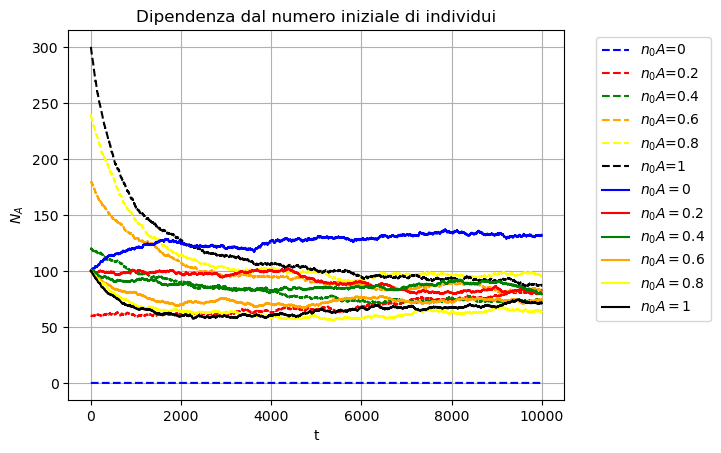

In [9]:

N=400
t_max=10000
k_max=6
t=np.linspace(0,t_max-1,t_max)

matriceA=matrix(k_max,t_max)
matriceB=matrix(k_max,t_max)

for k in range (0,k_max,1):
    n_0A=0.2*k*300
    n_0B=N/4
   

    n=np.zeros(t_max)
    m=np.zeros(t_max)
    
    ntot=np.zeros(t_max)
    mtot=np.zeros(t_max)
    

    
    n[0]=n_0A
    m[0]=n_0B
    

    samples=10
    

    for i in range (0,samples):
        

        nascita_morte(n,m,t_max-1)
        ntot=ntot+n
        mtot=mtot+m
        
    for j in range (0,t_max,1):
        matriceA[k][j]=ntot[j]/samples
        matriceB[k][j]=mtot[j]/samples
    


t=np.linspace(0,t_max-1,t_max)
plt.plot(t,matriceA[0],'--',label="$n_0A$=0  ",color='blue'  )
plt.plot(t,matriceA[1],'--',label="$n_0A$=0.2",color='red'   )
plt.plot(t,matriceA[2],'--',label="$n_0A$=0.4",color='green' )
plt.plot(t,matriceA[3],'--',label="$n_0A$=0.6",color='orange')
plt.plot(t,matriceA[4],'--',label="$n_0A$=0.8",color='yellow')
plt.plot(t,matriceA[5],'--',label="$n_0A$=1  ",color="black" )

plt.plot(t,matriceB[0],label="$n_0A=0  $",color='blue'  )
plt.plot(t,matriceB[1],label="$n_0A=0.2$",color='red'   )
plt.plot(t,matriceB[2],label="$n_0A=0.4$",color='green' )
plt.plot(t,matriceB[3],label="$n_0A=0.6$",color='orange')
plt.plot(t,matriceB[4],label="$n_0A=0.8$",color='yellow')
plt.plot(t,matriceB[5],label="$n_0A=1  $",color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel("t")
plt.ylabel(r"$N_A$")
plt.title(r"Dipendenza dal numero iniziale di individui")
n_0A=N/4 #torno a nomrale



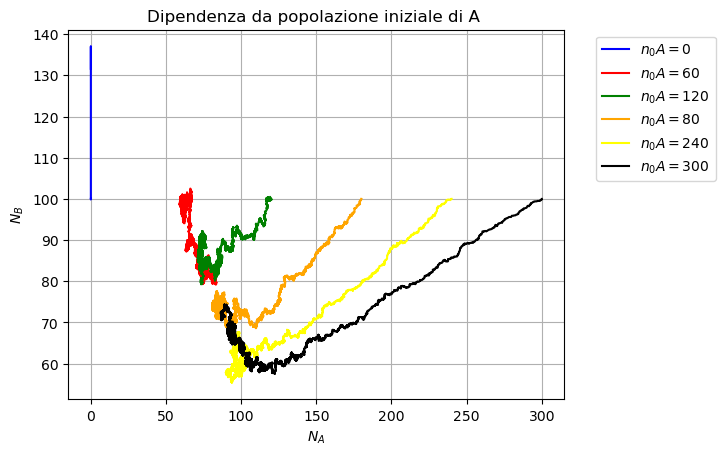

In [10]:
#spazio delle fasi


plt.plot(matriceA[0],matriceB[0],label="$n_0A=0$",color='blue'  )
plt.plot(matriceA[1],matriceB[1],label="$n_0A=60$",color='red'   )
plt.plot(matriceA[2],matriceB[2],label="$n_0A=120$",color='green' )
plt.plot(matriceA[3],matriceB[3],label="$n_0A=80$",color='orange')
plt.plot(matriceA[4],matriceB[4],label="$n_0A=240$",color='yellow')
plt.plot(matriceA[5],matriceB[5],label="$n_0A=300$" ,  color="black" )
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel(r"$N_A$")
plt.ylabel(r"$N_B$")
plt.title("Dipendenza da popolazione iniziale di A ")
plt.savefig("2pop_n0.png")